# Final Project: Correlation and Interpolation of Temperature in Lower Austria and Vienna

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from shapely.geometry import Point
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import rasterio
from rasterio.transform import from_origin
from scipy.stats import spearmanr

## 1. Processing temperature measurement data

In [2]:
# Load temmperature data
df = pd.read_csv('Temp_Data_NOE_VIE.csv')
df.head()

,time,station,Tmax
0,2024-06-01T00:00+00:00,11019,NaN
1,2024-06-01T00:00+00:00,11018,NaN
2,2024-06-01T00:00+00:00,11367,NaN
3,2024-06-01T00:00+00:00,11037,NaN
4,2024-06-01T00:00+00:00,11378,NaN


In [3]:
# Delete rows without values
df_cleaned = df.dropna(subset=['Tmax'])
df_cleaned.head()

,time,station,Tmax
223,2024-06-01T06:00+00:00,11018,13.4
224,2024-06-01T06:00+00:00,11367,11.7
225,2024-06-01T06:00+00:00,11037,18.3
226,2024-06-01T06:00+00:00,11378,14.1
227,2024-06-01T06:00+00:00,11384,10.2


In [4]:
# Load station metadata
stations = pd.read_csv('Stations_Metadata.csv')

stations.rename(columns={
    'id': 'id',
    'Klimastationsnummer': 'Climate Station Number',
    'Stationsname': 'Station Name',
    'Länge [°E]': 'Longitude [°E]',
    'Breite [°N]': 'Latitude [°N]',
    'Höhe [m]': 'Elevation [m]',
    'Startdatum': 'Start Date',
    'Enddatum': 'End Date',
    'Bundesland': 'Federal State'
}, inplace=True)


stations.head()

,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State
0,11330,15002,MAYRHOFEN,11.851667,47.162500,640,2007-08-28,2100-01-01,TIR
1,11328,8805,ACHENKIRCH,11.705278,47.532222,904,1998-09-24,2016-10-04,TIR
2,11375,10200,AFLENZ,15.240833,47.545833,783,1992-10-08,2100-01-01,STMK
3,11157,9801,AIGEN IM ENNSTAL,14.138333,47.532778,641,1972-01-01,2100-01-01,STMK
4,11301,11135,ALBERSCHWENDE,9.848611,47.457500,715,1996-01-16,2100-01-01,VBG


In [5]:
df_merged = pd.merge(stations, df_cleaned, left_on='id', right_on='station', how='inner')
df_merged.head()

,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State,time,station,Tmax
0,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-01T18:00+00:00,11019,16.0
1,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-02T18:00+00:00,11019,20.1
2,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-03T18:00+00:00,11019,19.0
3,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-04T18:00+00:00,11019,17.9
4,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-05T18:00+00:00,11019,24.1


In [6]:
## Extract date and time from the time column.

#Make sure that 'time' is recognized as a datetime
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Create new columns 'Datum' and 'Uhrzeit'
df_merged['date'] = df_merged['time'].dt.date
df_merged['time_of_day'] = df_merged['time'].dt.time

df_merged.head()

,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State,time,station,Tmax,date,time_of_day
0,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-01 18:00:00+00:00,11019,16.0,2024-06-01,18:00:00
1,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-02 18:00:00+00:00,11019,20.1,2024-06-02,18:00:00
2,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-03 18:00:00+00:00,11019,19.0,2024-06-03,18:00:00
3,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-04 18:00:00+00:00,11019,17.9,2024-06-04,18:00:00
4,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-05 18:00:00+00:00,11019,24.1,2024-06-05,18:00:00


In [7]:
## Create one dataset for nighttime and one for daytime

# Make sure that 'time_of_date' is the right time object
df_merged['time_of_day'] = pd.to_datetime(df_merged['time_of_day'], format='%H:%M:%S').dt.time

# Filter for 6:00 AM
df_6 = df_merged[df_merged['time_of_day'] == pd.to_datetime('06:00:00').time()]

# Filter for 6:00 PM
df_18 = df_merged[df_merged['time_of_day'] == pd.to_datetime('18:00:00').time()]

df_6.head()


,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State,time,station,Tmax,date,time_of_day
30,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-07-02 06:00:00+00:00,11019,19.0,2024-07-02,06:00:00
70,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-08-10 06:00:00+00:00,11019,16.7,2024-08-10,06:00:00
94,11018,5316,AMSTETTEN,14.895000,48.108889,266,1972-01-01,2100-01-01,NOE,2024-06-01 06:00:00+00:00,11018,13.4,2024-06-01,06:00:00
96,11018,5316,AMSTETTEN,14.895000,48.108889,266,1972-01-01,2100-01-01,NOE,2024-06-02 06:00:00+00:00,11018,14.2,2024-06-02,06:00:00
98,11018,5316,AMSTETTEN,14.895000,48.108889,266,1972-01-01,2100-01-01,NOE,2024-06-03 06:00:00+00:00,11018,19.9,2024-06-03,06:00:00


In [8]:
## Sort the dataset by date instead of station

# Sort by date (ascending)
df_6 = df_6.sort_values(by='date')
df_18 = df_18.sort_values(by='date')

df_18.head()

,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State,time,station,Tmax,date,time_of_day
0,11019,1906,ALLENTSTEIG,15.366944,48.690833,599,1988-05-30,2100-01-01,NOE,2024-06-01 18:00:00+00:00,11019,16.0,2024-06-01,18:00:00
5110,11034,5925,WIEN-INNERE STADT,16.366944,48.198333,177,1990-03-09,2100-01-01,WIE,2024-06-01 18:00:00+00:00,11034,19.6,2024-06-01,18:00:00
1368,11075,3811,LANGENLOIS,15.697222,48.472500,207,1990-07-04,2100-01-01,NOE,2024-06-01 18:00:00+00:00,11075,20.2,2024-06-01,18:00:00
5293,11035,5904,WIEN/HOHE WARTE,16.356389,48.248611,198,1972-01-01,2100-01-01,WIE,2024-06-01 18:00:00+00:00,11035,19.3,2024-06-01,18:00:00
1185,11024,3702,JAUERLING,15.339167,48.334444,955,1972-01-01,2100-01-01,NOE,2024-06-01 18:00:00+00:00,11024,13.6,2024-06-01,18:00:00


In [9]:
## Calculate the average of the maximum temperature from June to September for all stations

df_6['Tmax_mean'] = df_6.groupby('Station Name')['Tmax'].transform('mean')
df_18['Tmax_mean'] = df_18.groupby('Station Name')['Tmax'].transform('mean')

df_6.head()


,id,Climate Station Number,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Start Date,End Date,Federal State,time,station,Tmax,date,time_of_day,Tmax_mean
1184,11024,3702,JAUERLING,15.339167,48.334444,955,1972-01-01,2100-01-01,NOE,2024-06-01 06:00:00+00:00,11024,12.2,2024-06-01,06:00:00,18.624176
5292,11035,5904,WIEN/HOHE WARTE,16.356389,48.248611,198,1972-01-01,2100-01-01,WIE,2024-06-01 06:00:00+00:00,11035,17.3,2024-06-01,06:00:00,24.595604
3192,11380,10510,REICHENAU/RAX,15.836944,47.699722,488,1991-01-28,2100-01-01,NOE,2024-06-01 06:00:00+00:00,11380,15.6,2024-06-01,06:00:00,21.867416
3372,11022,905,RETZ,15.941667,48.761111,320,1972-01-01,2100-01-01,NOE,2024-06-01 06:00:00+00:00,11022,17.0,2024-06-01,06:00:00,24.210989
3736,11387,7710,SEIBERSDORF,16.505000,47.976389,185,2002-12-09,2100-01-01,NOE,2024-06-01 06:00:00+00:00,11387,18.3,2024-06-01,06:00:00,24.895604


In [10]:
## Only one row should remain per station


# Daytime
df_6_avg = df_6.groupby('station', as_index=False).agg({
    'Tmax_mean': 'first',
    'id': 'first',
    'Station Name': 'first',
    'Longitude [°E]': 'first',
    'Latitude [°N]': 'first',
    'Elevation [m]': 'first',
    'Federal State': 'first'
})


df_6_avg.to_csv('df_6_avg.csv', index=False)



# Nighttime
df_18_avg = df_18.groupby('station', as_index=False).agg({
    'Tmax_mean': 'first',
    'id': 'first',
    'Station Name': 'first',
    'Longitude [°E]': 'first',
    'Latitude [°N]': 'first',
    'Elevation [m]': 'first',
    'Federal State': 'first'
})


df_18_avg.to_csv('df_18_avg.csv', index=False)

df_18_avg.head()

,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State
0,11018,27.671739,11018,AMSTETTEN,14.895000,48.108889,266,NOE
1,11019,24.713187,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE
2,11020,25.804348,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE
3,11021,25.680435,11021,LITSCHAU,15.038333,48.954722,558,NOE
4,11022,28.082418,11022,RETZ,15.941667,48.761111,320,NOE


## 2. Interpolation of Temperature

In [11]:
##Load and prepare district boundaries

#Load
noe = gpd.read_file("districts_lower_austria.json")
vie = gpd.read_file("districts_vienna.json")

# Reproject to EPSG:25833 (metric system)
target_crs = "EPSG:25833"
noe = noe.to_crs(target_crs)
vie = vie.to_crs(target_crs)

# Combine both GeoDataFrames
combined = pd.concat([noe, vie], ignore_index=True)
combined_boundary = combined.dissolve()


In [12]:
# Get the bounding box of the Vienna & Lower Austria area
bounds = combined_boundary.total_bounds
minx, miny, maxx, maxy = bounds
grid_size = 100  #
x_grid = np.linspace(minx, maxx, grid_size)
y_grid = np.linspace(miny, maxy, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

### 2.1. Interpolation for Daytime

In [13]:
# Prepare station data
geometry18 = [Point(xy) for xy in zip(df_18_avg['Longitude [°E]'], df_18_avg['Latitude [°N]'])]
gdf_18_stations = gpd.GeoDataFrame(df_18_avg, geometry=geometry18, crs="EPSG:4326")
gdf_18_stations = gdf_18_stations.to_crs(target_crs)

# Extract X and Y coordinates
gdf_18_stations['X'] = gdf_18_stations.geometry.x
gdf_18_stations['Y'] = gdf_18_stations.geometry.y

In [14]:
# Prepare training data
target_column = 'Tmax_mean'
df_18_with_values = gdf_18_stations.dropna(subset=[target_column]).copy()
df_18_with_values[target_column] = df_18_with_values[target_column].astype(float)

X_18_train = df_18_with_values[['X', 'Y']].values
y_18_train = df_18_with_values[target_column].values

In [15]:
# Interpolation using KNN 
interpolator18 = KNeighborsRegressor(n_neighbors=5, weights='distance')
interpolator18.fit(X_18_train, y_18_train)

# Predict values on the grid
grid_values_18 = interpolator18.predict(grid_points)

# If NaN values are present, replace them with mean of trained temperature values
grid_values_18 = np.nan_to_num(grid_values_18, nan=np.mean(y_18_train))

grid_values_18= grid_values_18.reshape(xx.shape)


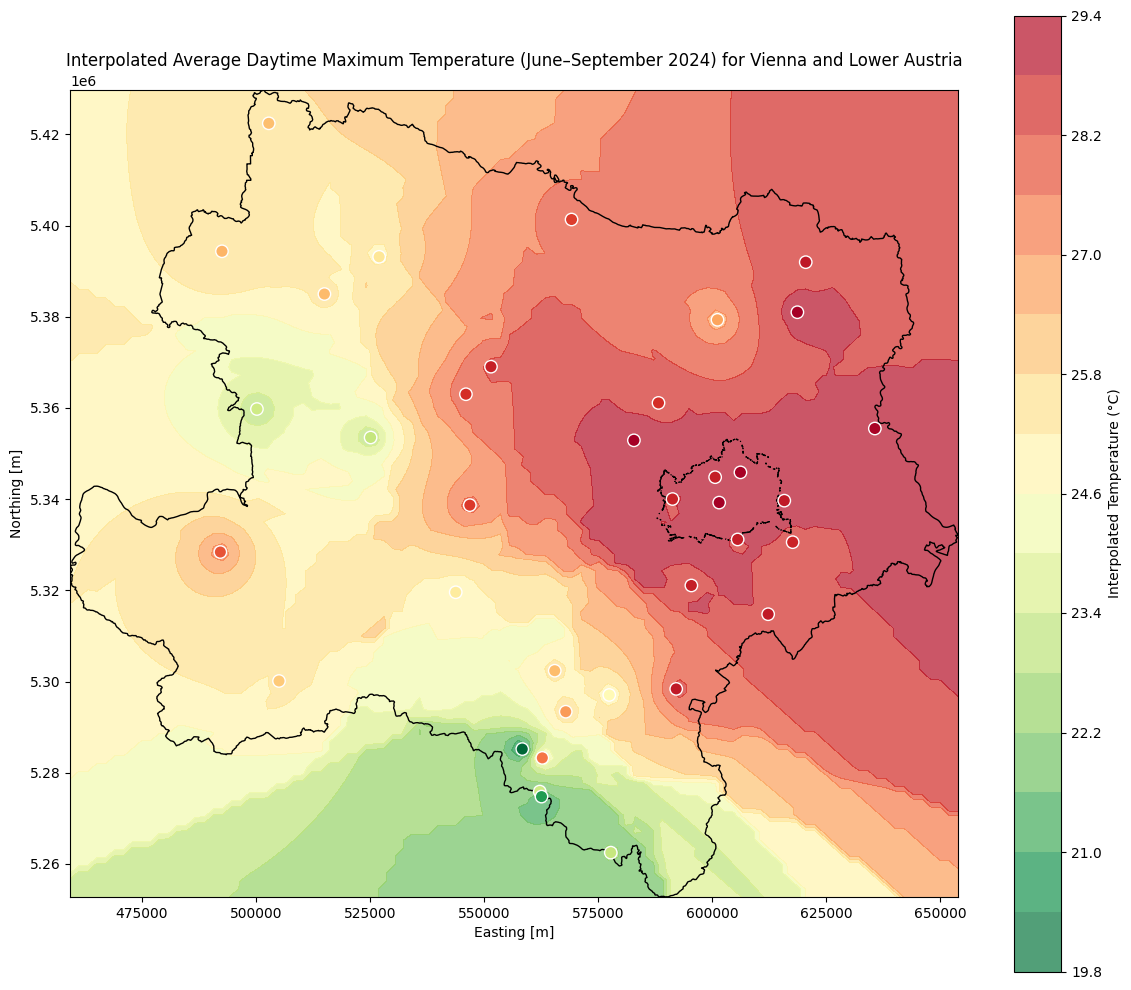

In [76]:
## Create plot of interpolation

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the interpolated surface as a filled contour
contour = ax.contourf(xx, yy, grid_values_18, cmap='RdYlGn_r', alpha=0.7, levels=15)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(f'Interpolated Temperature (°C)')

# Plot district boundaries of Vienna and Lower Austria
combined_boundary.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot the measurement stations
scatter = ax.scatter(
    X_18_train[:, 0], X_18_train[:, 1],
    c=y_18_train,
    cmap='RdYlGn_r',
    edgecolor='white',
    s=80,
    zorder=3
)

# Add title and axis labels
plt.title(f"Interpolated Average Daytime Maximum Temperature (June–September 2024) for Vienna and Lower Austria")
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')

# Adjust axes to fit the area
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.tight_layout()
plt.savefig('interpolated_temperature_Day_plot.png', dpi=300)
plt.show()

### 2.1. Interpolation for Nighttime

In [17]:
# Prepare station data
geometry6 = [Point(xy) for xy in zip(df_6_avg['Longitude [°E]'], df_6_avg['Latitude [°N]'])]
gdf_6_stations = gpd.GeoDataFrame(df_6_avg, geometry=geometry6, crs="EPSG:4326")
gdf_6_stations = gdf_6_stations.to_crs(target_crs)

# Extract X and Y coordinates
gdf_6_stations['X'] = gdf_6_stations.geometry.x
gdf_6_stations['Y'] = gdf_6_stations.geometry.y

gdf_6_stations.head()

,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State,geometry,X,Y
0,11018,24.091209,11018,AMSTETTEN,14.895000,48.108889,266,NOE,POINT (492183.969 5328408.231),492183.969141,5.328408e+06
1,11019,17.850000,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE,POINT (527004.911 5393153.036),527004.911172,5.393153e+06
2,11020,20.606593,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE,POINT (515006.241 5384987.397),515006.241177,5.384987e+06
3,11021,21.513187,11021,LITSCHAU,15.038333,48.954722,558,NOE,POINT (502806.313 5422423.169),502806.312963,5.422423e+06
4,11022,24.210989,11022,RETZ,15.941667,48.761111,320,NOE,POINT (569204.29 5401327.834),569204.290111,5.401328e+06


In [18]:
# Prepare training data
target_column = 'Tmax_mean'
df_6_with_values = gdf_6_stations.dropna(subset=[target_column]).copy()
df_6_with_values[target_column] = df_6_with_values[target_column].astype(float)

X_6_train = df_6_with_values[['X', 'Y']].values
y_6_train = df_6_with_values[target_column].values


In [19]:
# Interpolation using KNN 
interpolator6 = KNeighborsRegressor(n_neighbors=5, weights='distance')
interpolator6.fit(X_6_train, y_6_train)

# Predict values on the grid
grid_values_6 = interpolator6.predict(grid_points)

# If NaN values are present, replace them with mean of trained temperature values
grid_values_6 = np.nan_to_num(grid_values_6, nan=np.mean(y_6_train))

grid_values_6 = grid_values_6.reshape(xx.shape)


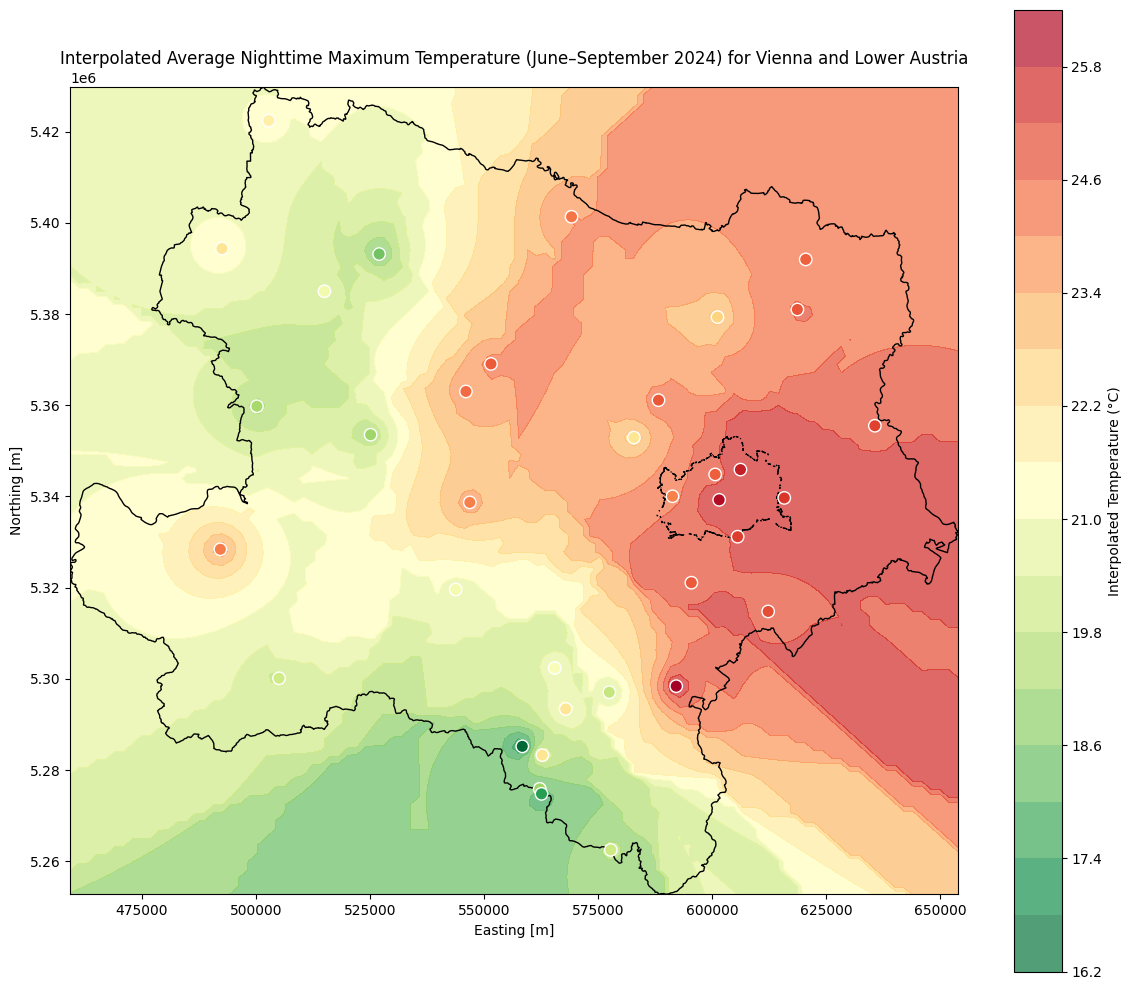

In [77]:
## Create plot of interpolation

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the interpolated surface as a filled contour
contour = ax.contourf(xx, yy, grid_values_6, cmap='RdYlGn_r', alpha=0.7, levels=15)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label(f'Interpolated Temperature (°C)')

# Plot district boundaries of Vienna and Lower Austria
combined_boundary.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot the measurement stations
scatter = ax.scatter(
    X_6_train[:, 0], X_6_train[:, 1],
    c=y_6_train,
    cmap='RdYlGn_r',
    edgecolor='white',
    s=80,
    zorder=3
)

# Add title and axis labels
plt.title(f"Interpolated Average Nighttime Maximum Temperature (June–September 2024) for Vienna and Lower Austria")
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')

# Adjust axes to fit the area
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.tight_layout()
plt.savefig('interpolated_temperature_Night_plot.png', dpi=300)
plt.show()


## 3. Correlation between Temperature and Elevation of Stations

### 3.1. Daytime

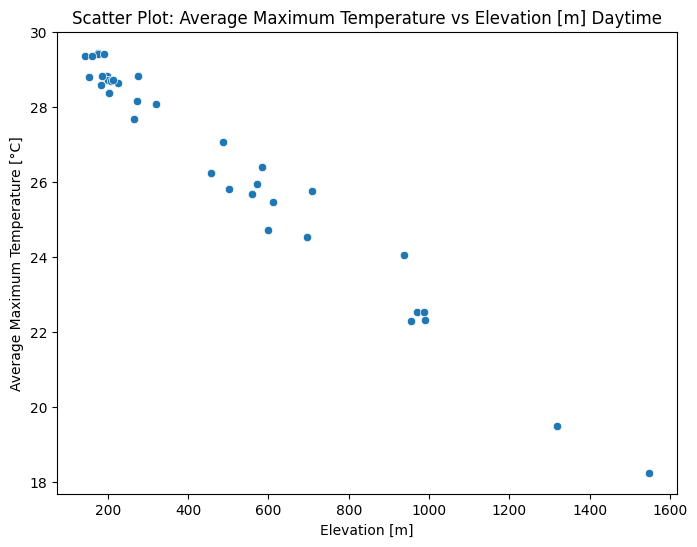

Pearson Correlation Coefficient: -0.988
P-value: 0.000


In [78]:
# Create Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_18_avg['Elevation [m]'], y=df_18_avg['Tmax_mean'])
plt.title('Scatter Plot: Average Maximum Temperature vs Elevation [m] Daytime')
plt.xlabel('Elevation [m]')
plt.ylabel('Average Maximum Temperature [°C]')
plt.savefig('correlation_elevation_temp_day.png', dpi=300)
plt.show()


# 2. Calculate Pearson Correlation and p-value
correlation, p_value = pearsonr(df_18_avg['Elevation [m]'], df_18_avg['Tmax_mean'])

# Print the correlation results
print(f"Pearson Correlation Coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

### 3.2. Nighttime

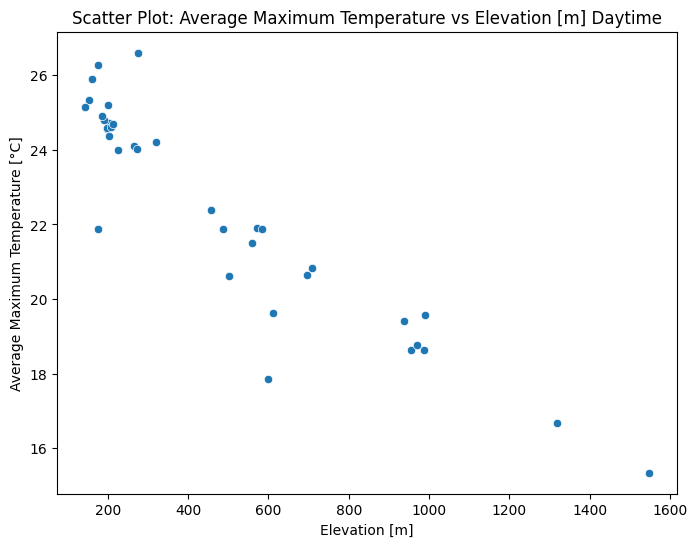

Pearson Correlation Coefficient: -0.927
P-value: 0.000


In [79]:
# Create Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_6_avg['Elevation [m]'], y=df_6_avg['Tmax_mean'])
plt.title('Scatter Plot: Average Maximum Temperature vs Elevation [m] Daytime')
plt.xlabel('Elevation [m]')
plt.ylabel('Average Maximum Temperature [°C]')
plt.savefig('correlation_elevation_temp_night.png', dpi=300)
plt.show()


# 2. Calculate Pearson Correlation and p-value
correlation, p_value = pearsonr(df_6_avg['Elevation [m]'], df_6_avg['Tmax_mean'])

# Print the correlation results
print(f"Pearson Correlation Coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")


## 4. Correlation between temperature and degree of urbanization

In [23]:
## Load and process municipality boundaries 

# Load municipality boundaries
muni = gpd.read_file("municipalities.shp", encoding='utf-8')
  
# Reproject municipalities to match the CRS of the temperature points
muni = muni.to_crs("EPSG:25833")

# Modify 'g_id' to set all Vienna districts to 'Wien'
muni.loc[muni['g_id'].astype(str).str.startswith('9'), 'g_id'] = '90001'

# Modify 'g_name' to set all Vienna districts to 'Wien'
muni.loc[muni['g_id'] == '90001', 'g_name'] = 'Wien'

muni.tail()

,g_id,g_name,geometry
2109,90001,Wien,"POLYGON ((599325.674 5343517.232, 599099.372 5..."
2110,90001,Wien,"POLYGON ((601617.6 5342249.12, 601564.538 5342..."
2111,90001,Wien,"POLYGON ((602883.41 5344763.015, 602879.024 53..."
2112,90001,Wien,"POLYGON ((606758.49 5340346.166, 606462.769 53..."
2113,90001,Wien,"POLYGON ((593312.758 5331515.502, 593310.985 5..."


In [24]:
# Load Urban-Rural-Typology
df_URT = pd.read_csv('Urban-Rural-Typology.csv', sep=';', skiprows=1)
df_URT = df_URT[['LAU', 'CODE']]
df_URT.head()

,LAU,CODE
0,10101,103
1,10201,410
2,10301,310
3,10302,310
4,10303,103


In [25]:
## Merge both datasets
df_URT['LAU'] = df_URT['LAU'].astype(str)
muni['g_id'] = muni['g_id'].astype(str)

URT_MUNI = df_URT.merge(muni, left_on='LAU', right_on='g_id', how='left')
URT_MUNI.head()

,LAU,CODE,g_id,g_name,geometry
0,10101,103,10101,Eisenstadt,"POLYGON ((612597.024 5296858.139, 612536.021 5..."
1,10201,410,10201,Rust,"POLYGON ((624767.11 5297980.457, 624766.72 529..."
2,10301,310,10301,Breitenbrunn am Neusiedler See,"POLYGON ((626996.393 5314767.304, 627027.126 5..."
3,10302,310,10302,Donnerskirchen,"POLYGON ((633108.41 5304959.043, 632705.078 53..."
4,10303,103,10303,Großhöflein,"POLYGON ((610988.936 5302490.843, 610999.345 5..."


In [26]:
## Create geodataframes for municipalities in Lower Austria, Vienna and both federal states

URT_muni_N = gpd.GeoDataFrame(
    URT_MUNI[URT_MUNI['LAU'].astype(str).str.startswith(('3'))],
    geometry='geometry',
)
URT_muni_W= gpd.GeoDataFrame(
    URT_MUNI[URT_MUNI['LAU'].astype(str).str.startswith(('9'))],
    geometry='geometry',
)

URT_muni_WN= gpd.GeoDataFrame(
    URT_MUNI[URT_MUNI['LAU'].astype(str).str.startswith(('9', '3'))],
    geometry='geometry',
)
URT_muni_W.head()

,LAU,CODE,g_id,g_name,geometry
2091,90001,101,90001,Wien,"POLYGON ((601696.273 5339513.729, 601693.928 5..."
2092,90001,101,90001,Wien,"POLYGON ((602389.673 5340783.723, 602366.11 53..."
2093,90001,101,90001,Wien,"POLYGON ((602649.595 5338170.6, 602619.652 533..."
2094,90001,101,90001,Wien,"POLYGON ((601663.354 5337757.575, 601600.94 53..."
2095,90001,101,90001,Wien,"POLYGON ((601038.933 5337269.63, 601022.285 53..."


### 4.1. Create Map of Urbanization Degree

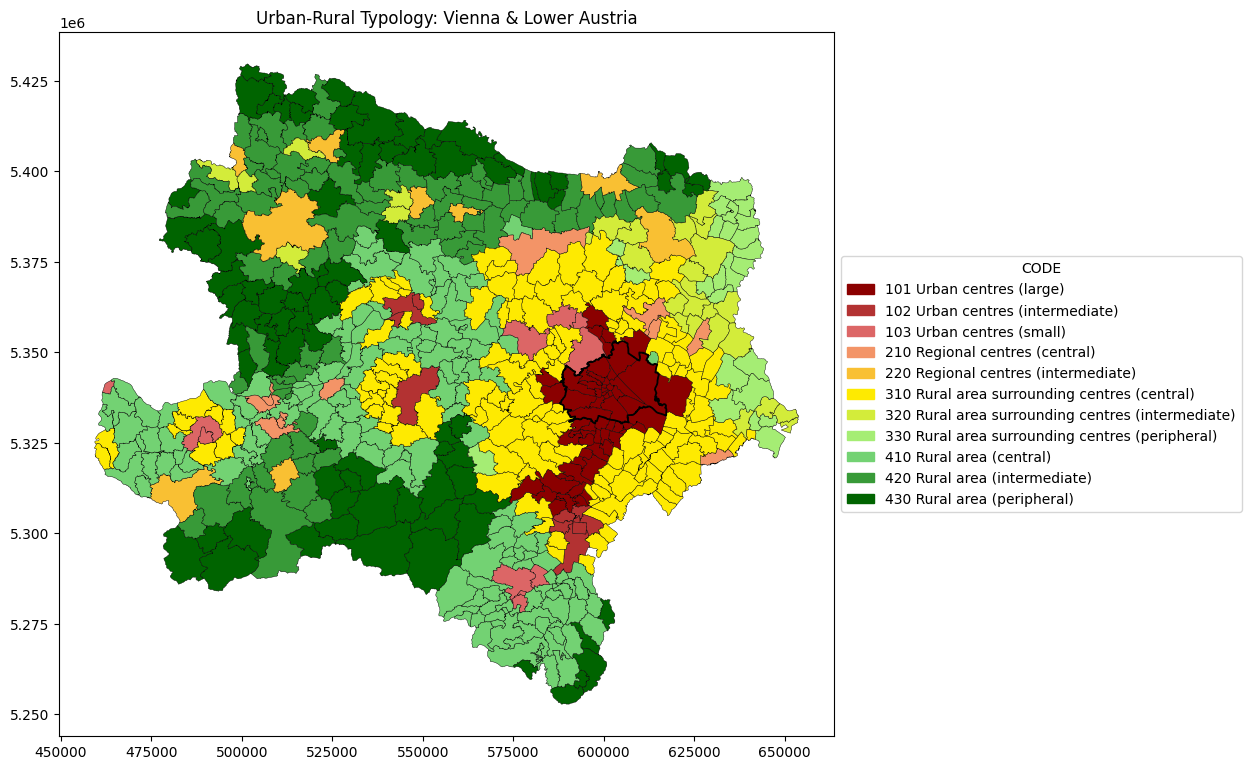

In [27]:
# 1. Color definition
ordered_codes = [101, 102, 103, 210, 220, 310, 320, 330, 410, 420, 430]
labels = [
    'Urban centres (large)', 'Urban centres (intermediate)', 'Urban centres (small)',
    'Regional centres (central)', 'Regional centres (intermediate)', 
    'Rural area surrounding centres (central)', 'Rural area surrounding centres (intermediate)', 
    'Rural area surrounding centres (peripheral)', 'Rural area (central)', 
    'Rural area (intermediate)', 'Rural area (peripheral)'
]
colors = [mcolors.LinearSegmentedColormap.from_list('custom', 
          ['darkred', 'lightcoral', '#FFEA00', 'lightgreen', 'darkgreen'])(i / (len(ordered_codes)-1))
          for i in range(len(ordered_codes))]
code_to_color = dict(zip(ordered_codes, colors))

# 2. Assign colors
URT_muni_N['color'] = URT_muni_N['CODE'].map(code_to_color)
URT_muni_W['color'] = URT_muni_W['CODE'].map(code_to_color)

# 3. Dissolve: create Vienna city boundary (merge all districts)
wien_dissolved = URT_muni_W.dissolve()  # merges all in URT_W since it contains only Vienna

# 4. Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# 5. Plot municipalities in Lower Austria and Vienna
URT_muni_N.plot(color=URT_muni_N['color'], ax=ax, edgecolor='black', linewidth=0.3)
URT_muni_W.plot(color=URT_muni_W['color'], ax=ax, edgecolor='black', linewidth=0.3)

# 6. Vienna city boundary with thicker border
wien_dissolved.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.3)

# 7. Legend
patches = [mpatches.Patch(color=code_to_color[code], label=f'{code} {label}') 
           for code, label in zip(ordered_codes, labels)]
ax.legend(handles=patches, title="CODE", loc='lower left', frameon=True)

# 8. Layout
ax.set_title('Urban-Rural Typology: Vienna & Lower Austria')
ax.axis('on')
ax.legend(handles=patches, title="CODE", loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
plt.show()

### 4.2. Correlation of Temperature and Urbanization

#### 4.2.1. Daytime

In [53]:
# Perform spatial join between the URT_muni dataframe and the temperature station data
URT_muni_18 = gpd.sjoin(df_18_with_values, URT_muni_WN, how="left", predicate="within")

# View the results
URT_muni_18.head()

,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State,geometry,X,Y,index_right,LAU,CODE,g_id,g_name,centroid,Urban_degree_ordinal,interpolated_temperature
0,11018,27.671739,11018,AMSTETTEN,14.895000,48.108889,266,NOE,POINT (492183.969 5328408.231),492183.969141,5.328408e+06,308.0,30502,103.0,30502,Amstetten,POINT (488986.466 5327990.161),3.0,22.920549
1,11019,24.713187,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE,POINT (527004.911 5393153.036),527004.911172,5.393153e+06,852.0,32501,430.0,32501,Allentsteig,POINT (524205.412 5392376.217),11.0,19.262955
2,11020,25.804348,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE,POINT (515006.241 5384987.397),515006.241177,5.384987e+06,875.0,32530,220.0,32530,Zwettl-Niederösterreich,POINT (512060.437 5384988.94),5.0,20.163650
3,11021,25.680435,11021,LITSCHAU,15.038333,48.954722,558,NOE,POINT (502806.313 5422423.169),502806.312963,5.422423e+06,462.0,30925,430.0,30925,Litschau,POINT (502837.972 5420988.804),11.0,21.321023
4,11022,28.082418,11022,RETZ,15.941667,48.761111,320,NOE,POINT (569204.29 5401327.834),569204.290111,5.401328e+06,485.0,31037,430.0,31037,Retz,POINT (570602.128 5400145.464),11.0,23.947639


In [61]:
# Assign an urbanisation code a value from 1 to 11 to create an ordinal level of measurement.

urban_ranking = [101, 102, 103, 210, 220, 310, 320, 330, 410, 420, 430]

# Each code is assigned a rank from 1 to 11
mapping = {k: i+1 for i, k in enumerate(urban_ranking)}
URT_muni_18['Urban_degree_ordinal'] = URT_muni_18['CODE'].map(mapping)

URT_muni_18.head()


,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State,geometry,X,Y,index_right,LAU,CODE,g_id,g_name,centroid,Urban_degree_ordinal,interpolated_temperature
0,11018,27.671739,11018,AMSTETTEN,14.895000,48.108889,266,NOE,POINT (492183.969 5328408.231),492183.969141,5.328408e+06,308.0,30502,103.0,30502,Amstetten,POINT (488986.466 5327990.161),3.0,22.920549
1,11019,24.713187,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE,POINT (527004.911 5393153.036),527004.911172,5.393153e+06,852.0,32501,430.0,32501,Allentsteig,POINT (524205.412 5392376.217),11.0,19.262955
2,11020,25.804348,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE,POINT (515006.241 5384987.397),515006.241177,5.384987e+06,875.0,32530,220.0,32530,Zwettl-Niederösterreich,POINT (512060.437 5384988.94),5.0,20.163650
3,11021,25.680435,11021,LITSCHAU,15.038333,48.954722,558,NOE,POINT (502806.313 5422423.169),502806.312963,5.422423e+06,462.0,30925,430.0,30925,Litschau,POINT (502837.972 5420988.804),11.0,21.321023
4,11022,28.082418,11022,RETZ,15.941667,48.761111,320,NOE,POINT (569204.29 5401327.834),569204.290111,5.401328e+06,485.0,31037,430.0,31037,Retz,POINT (570602.128 5400145.464),11.0,23.947639


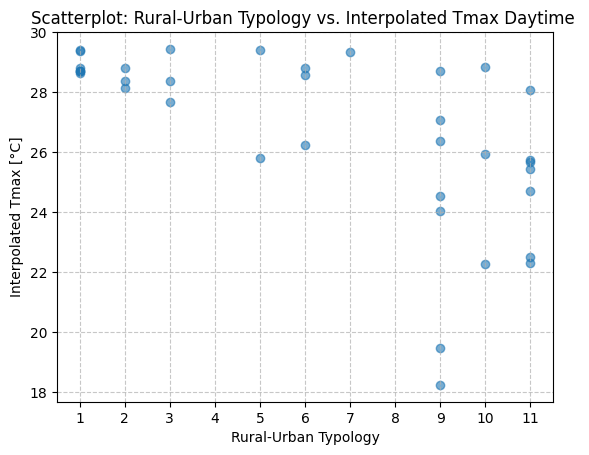

Spearman rank-order correlation: -0.663
p-Value: 1.051e-05


In [80]:
## Make Scatterplot and use Spearman rank-order correlation to determine correlation (
## (because we have ordinal and metric level of measurement)

# Delete row with NaN values
URT_muni_18_clean = URT_muni_18[['Urban_degree_ordinal', 'Tmax_mean']].dropna()


## Scatterplot
plt.scatter(URT_muni_18_clean['Urban_degree_ordinal'], URT_muni_18_clean['Tmax_mean'], alpha=0.6)
plt.xlabel('Rural-Urban Typology')
plt.ylabel('Interpolated Tmax [°C]')
plt.title('Scatterplot: Rural-Urban Typology vs. Interpolated Tmax Daytime ')
plt.xticks(ticks=range(1, 12)) 
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.grid(True)
plt.savefig('correlation_Urbanization_temp_day.png', dpi=300)
plt.show()


# Correlation and p-value
correlation, p_value = spearmanr(URT_muni_18_clean['Urban_degree_ordinal'], URT_muni_18_clean['Tmax_mean'])
print(f"Spearman rank-order correlation: {correlation:.3f}")
print(f"p-Value: {p_value:.3e}")

#### 4.2.2. Nighttime

In [64]:
# Perform spatial join between the URT_muni dataframe and the temperature station data
URT_muni_6 = gpd.sjoin(df_6_with_values, URT_muni_WN, how="left", predicate="within")

# View the results
URT_muni_6.head()

,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State,geometry,X,Y,index_right,LAU,CODE,g_id,g_name,centroid,Urban_degree_ordinal,interpolated_temperature
0,11018,24.091209,11018,AMSTETTEN,14.895000,48.108889,266,NOE,POINT (492183.969 5328408.231),492183.969141,5.328408e+06,308.0,30502,103.0,30502,Amstetten,POINT (488986.466 5327990.161),3.0,22.920549
1,11019,17.850000,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE,POINT (527004.911 5393153.036),527004.911172,5.393153e+06,852.0,32501,430.0,32501,Allentsteig,POINT (524205.412 5392376.217),11.0,19.262955
2,11020,20.606593,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE,POINT (515006.241 5384987.397),515006.241177,5.384987e+06,875.0,32530,220.0,32530,Zwettl-Niederösterreich,POINT (512060.437 5384988.94),5.0,20.163650
3,11021,21.513187,11021,LITSCHAU,15.038333,48.954722,558,NOE,POINT (502806.313 5422423.169),502806.312963,5.422423e+06,462.0,30925,430.0,30925,Litschau,POINT (502837.972 5420988.804),11.0,21.321023
4,11022,24.210989,11022,RETZ,15.941667,48.761111,320,NOE,POINT (569204.29 5401327.834),569204.290111,5.401328e+06,485.0,31037,430.0,31037,Retz,POINT (570602.128 5400145.464),11.0,23.947639


In [65]:
## Assign an urbanisation code a value from 1 to 11 to create an ordinal level of measurement.

# Each code is assigned a rank from 1 to 11
mapping = {k: i+1 for i, k in enumerate(urban_ranking)}
URT_muni_6['Urban_degree_ordinal'] = URT_muni_6['CODE'].map(mapping)

URT_muni_6.head()

,station,Tmax_mean,id,Station Name,Longitude [°E],Latitude [°N],Elevation [m],Federal State,geometry,X,Y,index_right,LAU,CODE,g_id,g_name,centroid,Urban_degree_ordinal,interpolated_temperature
0,11018,24.091209,11018,AMSTETTEN,14.895000,48.108889,266,NOE,POINT (492183.969 5328408.231),492183.969141,5.328408e+06,308.0,30502,103.0,30502,Amstetten,POINT (488986.466 5327990.161),3.0,22.920549
1,11019,17.850000,11019,ALLENTSTEIG,15.366944,48.690833,599,NOE,POINT (527004.911 5393153.036),527004.911172,5.393153e+06,852.0,32501,430.0,32501,Allentsteig,POINT (524205.412 5392376.217),11.0,19.262955
2,11020,20.606593,11020,STIFT ZWETTL,15.203611,48.617778,502,NOE,POINT (515006.241 5384987.397),515006.241177,5.384987e+06,875.0,32530,220.0,32530,Zwettl-Niederösterreich,POINT (512060.437 5384988.94),5.0,20.163650
3,11021,21.513187,11021,LITSCHAU,15.038333,48.954722,558,NOE,POINT (502806.313 5422423.169),502806.312963,5.422423e+06,462.0,30925,430.0,30925,Litschau,POINT (502837.972 5420988.804),11.0,21.321023
4,11022,24.210989,11022,RETZ,15.941667,48.761111,320,NOE,POINT (569204.29 5401327.834),569204.290111,5.401328e+06,485.0,31037,430.0,31037,Retz,POINT (570602.128 5400145.464),11.0,23.947639


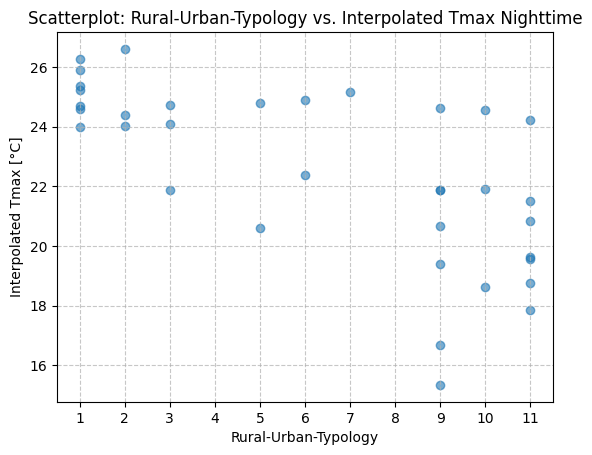

Spearman rank-order correlation: -0.680
p-Value: 6.926e-06


In [81]:
## Make scatterplot and use Spearman rank-order correlation to determine correlation 
##(because we have ordinal and metric level of measurement)

# Delete row with NaN values
URT_muni_6_clean = URT_muni_6[['Urban_degree_ordinal', 'Tmax_mean']].dropna()


## Scatterplot
plt.scatter(URT_muni_6_clean['Urban_degree_ordinal'], URT_muni_6_clean['Tmax_mean'], alpha=0.6)
plt.xlabel('Rural-Urban-Typology')
plt.ylabel('Interpolated Tmax [°C]')
plt.title('Scatterplot: Rural-Urban-Typology vs. Interpolated Tmax Nighttime')
plt.xticks(ticks=range(1, 12)) 
plt.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.grid(True)
plt.savefig('correlation_Urbanization_temp_night.png', dpi=300)
plt.show()



# Correlation and p-value
correlation, p_value = spearmanr(URT_muni_6_clean['Urban_degree_ordinal'], URT_muni_6_clean['Tmax_mean'])
print(f"Spearman rank-order correlation: {correlation:.3f}")
print(f"p-Value: {p_value:.3e}")
